# Projeto: Classificador de Qualidade de Diamantes com KNN
# Objetivo: Treinar um modelo KNN para prever a qualidade de diamantes com base em características numéricas e categóricas


## Importações


In [1]:
# Importando as biliotecas necessárias
import os
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Carregando o dataset

In [2]:
# Baixando o dataset
URL = "https://raw.githubusercontent.com/tidyverse/ggplot2/main/data-raw/diamonds.csv"
DATASET_PATH = os.path.join("dataset", "diamonds.csv")
os.makedirs("dataset", exist_ok=True) # Cria uma pasta chamada "dataset" para baixar o dataset
urllib.request.urlretrieve(URL, DATASET_PATH)

diamonds = pd.read_csv(DATASET_PATH)

## Exploração dos Dados

In [4]:
# Exibindo as primeiras 10 linhas do dataframe
diamonds.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [5]:
# Visualizando o resumo das colunas
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [6]:
# Visualizando a descrição das principais medidas estatísticas
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## Tratamento e Pré-processamento dos Dados

In [7]:
# Verificando a existência de valores ausentes
diamonds.isnull().sum()

,0
carat,0
cut,0
color,0
clarity,0
depth,0
table,0
price,0
x,0
y,0
z,0


In [8]:
# Verificando a existência de dados duplicados
diamonds.duplicated().sum()

np.int64(146)

Devido a existência de dados duplicados, é preciso remover esses registros.

In [9]:
# Removendo os dados duplicados
diamonds.drop_duplicates(inplace=True)

# Verificando se não há mais dados duplicados
assert diamonds.duplicated().sum() == 0, "Ainda há valores duplicados no dataset."

###  Conversão de variáveis em categóricas ordenadas

In [10]:
# Verificando os tipos de dados de cada coluna
diamonds.dtypes

,0
carat,float64
cut,object
color,object
clarity,object
depth,float64
table,float64
price,int64
x,float64
y,float64
z,float64


Nota-se que as colunas 'cut', 'color' e 'clarity' possem o tipo de dado 'object', ou seja, são tratadas como categorias sem ordenação, o que não é adequado para este caso, haja visto que há uma hierarquia implícita entre os valores dessas colunas. Dessa forma, se faz necessário converter os tipos de dados de 'object' para o tipo categório ordenado.

In [11]:
# Ordenando as categorias com sentido lógico
diamonds['cut'] = pd.Categorical(diamonds['cut'],
    categories=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ordered=True)

diamonds['color'] = pd.Categorical(diamonds['color'],
    categories=['J', 'I', 'H', 'G', 'F', 'E', 'D'], ordered=True)

diamonds['clarity'] = pd.Categorical(diamonds['clarity'],
    categories=['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'], ordered=True)


# Verificando os tipos de dados
diamonds.dtypes

,0
carat,float64
cut,category
color,category
clarity,category
depth,float64
table,float64
price,int64
x,float64
y,float64
z,float64


As três colunas ('cut', 'color' e 'clarity') agora possuem o tipo de dado 'category'.

### Conversão de variáveis categóricas ordinais para numéricas


Em razão de as colunas 'color' e 'clarity' representarem níveis de qualidade dos diamantes, seguindo uma ordem específica, deve-se transformar as categorias presentes nessas colunas em números. Assim, o modelo entenderá a ordenação.

In [12]:
# Convertendo as categorias ordenadas para códigos numéricos
diamonds['color_code'] = diamonds['color'].cat.codes
diamonds['clarity_code'] = diamonds['clarity'].cat.codes

### Definição das features (X) e variável-alvo (y)

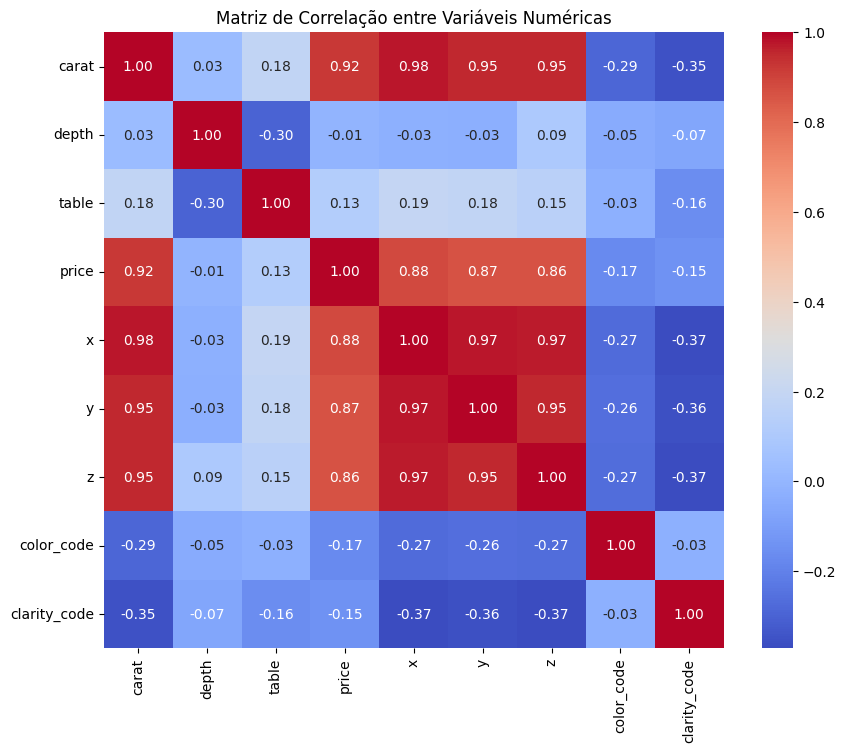

Pares com correlação forte (> 0.9):
   Feature 1 Feature 2  Correlation
2      carat     price     0.921548
3      carat         x     0.975380
4      carat         y     0.951908
5      carat         z     0.953542
26         x         y     0.974592
27         x         z     0.970686
30         y         z     0.951844


In [13]:
# Matriz de correlação
correlation_matrix = diamonds.corr(numeric_only=True)

# Mapa de calor da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.show()

# Identificando pares altamente correlacionados
threshold = 0.9
correlated_pairs = (
    correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
correlated_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr = correlated_pairs[correlated_pairs['Correlation'].abs() > threshold]

# Exibindo os pares com correlação alta
print("Pares com correlação forte (> 0.9):")
print(high_corr)


In [14]:
# Definindo as colunas que serão usadas como features
features = ['carat', 'depth', 'table', 'x', 'y', 'z']

# Definindo a variável alvo (target) da classificação
target = 'cut'

# Separando os dados de entrada (X) e saída (y)
X = diamonds[features]
y = diamonds[target]

### Normalização dos Dados

In [15]:
# Aplicando a normalização nos dados de entrada
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Dessa forma, cada coluna passa a ter média 0 e desvio-padrão 1, equilibrando o impacto que essas colunas podem exercer sobre a classificação.

### Separação dos conjuntos de teste, treino e validação.


In [16]:
# Dividindo os dados em conjunto de teste (20%) e o restante (80%) para treino e validação
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Dividindo os 80% restantes em treino (60%) e validação (20%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Verificando os tamanhos
len(X_train), len(X_val), len(X_test)

(32276, 10759, 10759)

## Exploração de hiperparâmetros

Testando valores para `k` com o objetivo de descobrir qual gera a melhor acurácia no conjunto de validação.

In [17]:
# Testando valores para k de 1 a 20
k_values = list(range(1, 21))
accuracy_values = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    predict = knn.predict(X_val)
    accuracy = accuracy_score(y_val, predict)
    accuracy_values.append(accuracy)

### Visualizando os resultados

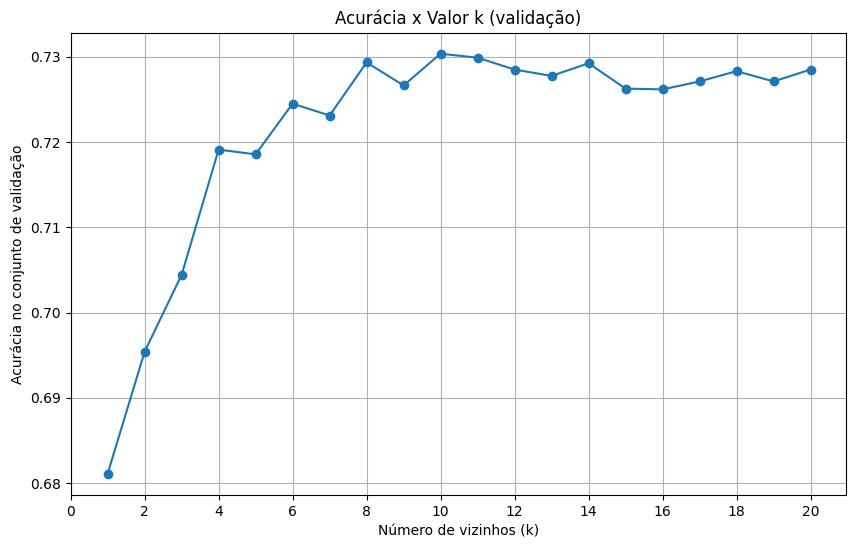

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_values, marker='o')
plt.xticks(range(0, 21, 2))
plt.xlabel("Número de vizinhos (k)")
plt.ylabel("Acurácia no conjunto de validação")
plt.title("Acurácia x Valor k (validação)")
plt.grid(True)
plt.show()

Ao visualizar o gráfico, nota-se que o melhor valor para `k` é 10.

In [19]:
best_k = k_values[accuracy_values.index(max(accuracy_values))]
print(f'O melhor valor para k é {best_k}.')

O melhor valor para k é 10.


## Treinamento do Modelo Final


In [20]:
# Treinamento do modelo com o melhor valor de k encontrado
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

### Avaliação no conjunto de teste

In [21]:
predict = model.predict(X_test)


### Matriz de confusão

In [22]:
matrix = confusion_matrix(y_test, predict)
matrix

array([[ 258,   60,    2,    8,    2],
       [  24,  607,   20,  106,  236],
       [   2,   12, 3986,  223,  133],
       [   1,   37,  321, 2061,  244],
       [   2,  198,  619,  733,  864]])

#### Visualizando graficamente a matriz de confusão

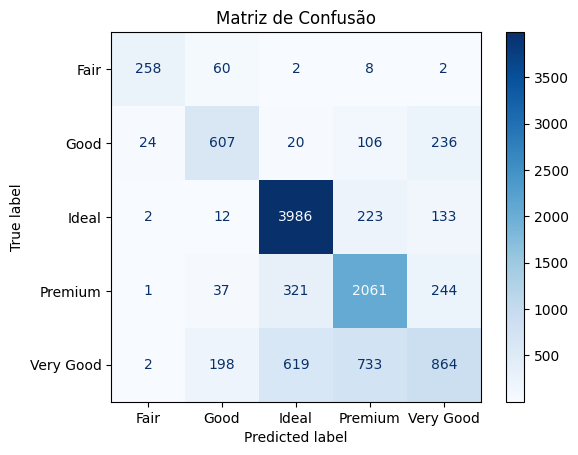

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão")
plt.show()

## Acurácia final

In [24]:
# Verificando a acurácia
test_accuracy = accuracy_score(y_test, predict)
print(f"Acurácia no conjunto de teste: {test_accuracy}")

Acurácia no conjunto de teste: 0.722743749419091
